In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("../")
from common.dataloader import load_dataset

In [74]:
from pyts.approximation import SymbolicAggregateApproximation
from sklearn.preprocessing import StandardScaler
from common import data_preprocess

In [4]:
dataset = "SMD"
subdataset = "machine-1-1"
data_dict = load_dataset(
        dataset,
        subdataset,
        "all",
    root_dir="."
    )

././datasets/anomaly/SMD/processed/machine-1-1_train.pkl
Shape of train is (28479, 38).
Shape of test is (28479, 38).
Shape of test_labels is (28479,).


In [5]:
ts = data_dict["train"]
scaler = StandardScaler()
ts = scaler.fit_transform(ts.T)

In [75]:
pp = data_preprocess.preprocessor()
data_dict = pp.normalize(data_dict, method="standard")

In [81]:
data_dict["train"].T[:, :nrows].shape

(38, 1000)

In [4]:
import pandas as pd
x = {
    "a": [1,2],
    "b": [2,3]
}
y = pd.DataFrame(x, index = ["c","f"])
y

,a,b
c,1,2
f,2,3


In [116]:
data_dict["test_tokens"]

array([['p', 'p', 'r', ..., 'o', 'r', 'r'],
       ['q', 's', 's', ..., 'g', 'r', 'r'],
       ['p', 'o', 'r', ..., 'u', 'r', 'r'],
       ...,
       ['w', 'w', 'y', ..., 'u', 'z', 'z'],
       ['w', 'z', 'z', ..., 'o', 'y', 'y'],
       ['w', 't', 'y', ..., 'o', 'y', 'y']], dtype='<U1')

In [130]:
x  = data_dict["test_tokens"]
postfix = np.array([["_"+str(i)]*x.shape[0] for i in range(x.shape[1])]).T
test_tokens = np.char.add(x, postfix)

In [131]:
np.unique(test_tokens)

array(['a_11', 'a_12', 'a_13', 'a_18', 'a_6', 'a_8', 'a_9', 'b_10',
       'b_11', 'b_12', 'b_18', 'b_19', 'b_21', 'b_27', 'b_6', 'b_9',
       'c_1', 'c_11', 'c_12', 'c_13', 'c_14', 'c_18', 'c_19', 'c_21',
       'c_4', 'c_6', 'c_8', 'c_9', 'd_1', 'd_11', 'd_12', 'd_13', 'd_14',
       'd_16', 'd_18', 'd_19', 'd_2', 'd_20', 'd_21', 'd_25', 'd_3',
       'd_4', 'd_6', 'd_8', 'd_9', 'e_0', 'e_1', 'e_11', 'e_12', 'e_13',
       'e_14', 'e_15', 'e_16', 'e_17', 'e_18', 'e_19', 'e_2', 'e_20',
       'e_21', 'e_22', 'e_24', 'e_25', 'e_26', 'e_3', 'e_6', 'e_8', 'f_0',
       'f_1', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16',
       'f_17', 'f_18', 'f_19', 'f_2', 'f_20', 'f_21', 'f_22', 'f_24',
       'f_25', 'f_28', 'f_29', 'f_3', 'f_6', 'f_8', 'g_1', 'g_11', 'g_12',
       'g_13', 'g_14', 'g_15', 'g_16', 'g_17', 'g_18', 'g_19', 'g_2',
       'g_20', 'g_21', 'g_22', 'g_24', 'g_25', 'g_27', 'g_28', 'g_29',
       'g_3', 'g_6', 'g_8', 'g_9', 'h_0', 'h_1', 'h_11', 'h_12', 'h_13',
   

In [111]:
nrows = 1000
n_bins = 26
strategy = "normal"

sax = SymbolicAggregateApproximation(n_bins=n_bins, strategy=strategy)
train_sax = sax.fit_transform(data_dict["train"].T[:, :nrows])
test_sax = sax.transform(data_dict["test"].T[:, :nrows])

data_dict["train_tokens"] = train_sax.T
data_dict["test_tokens"] = test_sax.T
# test_sax = sax.fit_transform(ts[0:1000])

In [112]:
data_dict["train"].shape, data_dict["train_tokens"].shape

((28479, 30), (1000, 30))

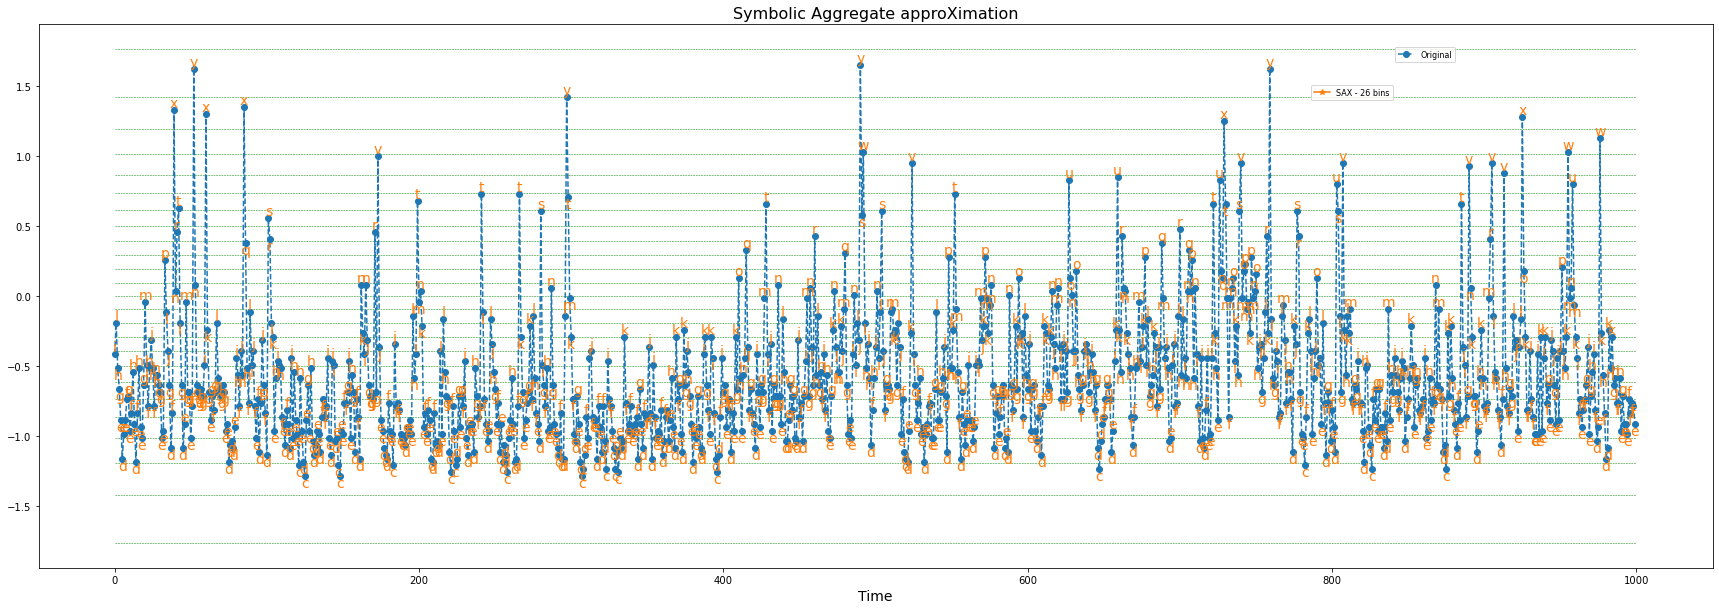

In [113]:
import numpy as np
from scipy.stats import norm
import matplotlib.lines as mlines
import matplotlib.pyplot as plt


X = data_dict["train"][:1000, 1].reshape(1, -1)
X_sax = data_dict["train_tokens"][:1000, 1].reshape(1, -1)
n_bins = 26

n_samples = 1
n_timestamps = X.shape[1]
# Compute gaussian bins
bins = norm.ppf(np.linspace(0, 1, n_bins + 1)[1:-1])

# Show the results for the first time series
bottom_bool = np.r_[True, X_sax[0, 1:] > X_sax[0, :-1]]

plt.figure(figsize=(30, 10))
plt.plot(X[0], 'o--', label='Original')
for x, y, s, bottom in zip(range(n_timestamps), X[0], X_sax[0], bottom_bool):
    va = 'bottom' if bottom else 'top'
    plt.text(x, y, s, ha='center', va=va, fontsize=14, color='#ff7f0e')
plt.hlines(bins, 0, n_timestamps, color='g', linestyles='--', linewidth=0.5)
sax_legend = mlines.Line2D([], [], color='#ff7f0e', marker='*',
                           label='SAX - {0} bins'.format(n_bins))
first_legend = plt.legend(handles=[sax_legend], fontsize=8, loc=(0.76, 0.86))
ax = plt.gca().add_artist(first_legend)
plt.legend(loc=(0.81, 0.93), fontsize=8)
plt.xlabel('Time', fontsize=14)
plt.title('Symbolic Aggregate approXimation', fontsize=16)
plt.show()

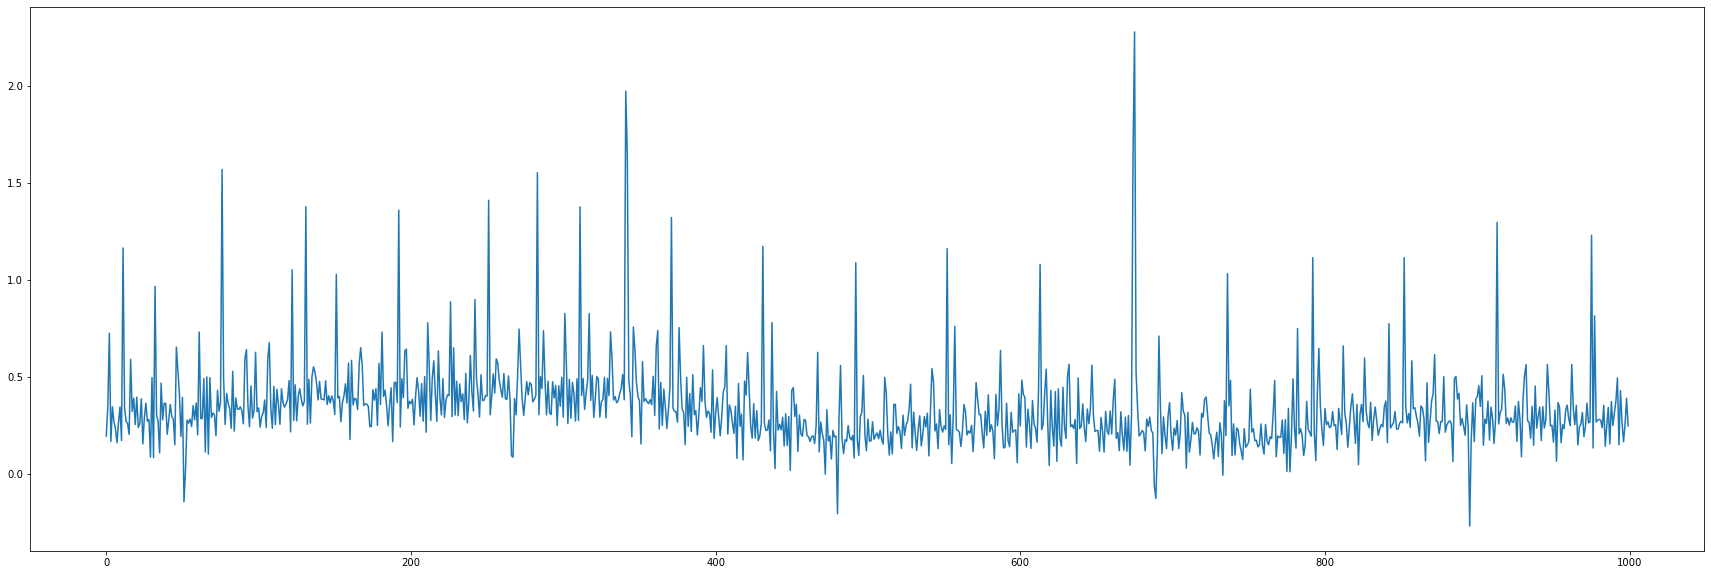

In [61]:
plt.figure(figsize=(30, 10))
plt.plot(ts_dim)

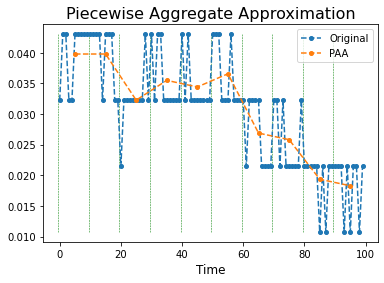

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.approximation import PiecewiseAggregateApproximation

# Parameters
n_samples, n_timestamps = 1, 100

# Toy dataset
rng = np.random.RandomState(41)
X = rng.randn(n_samples, n_timestamps)
X = ts_dim.reshape(1,-1)[:, 0:100]

# PAA transformation
window_size = 10
paa = PiecewiseAggregateApproximation(window_size=window_size)
X_paa = paa.transform(X)

# Show the results for the first time series
plt.figure(figsize=(6, 4))
plt.plot(X[0], 'o--', ms=4, label='Original')
plt.plot(np.arange(window_size // 2,
                   n_timestamps + window_size // 2,
                   window_size), X_paa[0], 'o--', ms=4, label='PAA')
plt.vlines(np.arange(0, n_timestamps, window_size) - 0.5,
           X[0].min(), X[0].max(), color='g', linestyles='--', linewidth=0.5)
plt.legend(loc='best', fontsize=10)
plt.xlabel('Time', fontsize=12)
plt.title('Piecewise Aggregate Approximation', fontsize=16)
plt.show()

In [44]:
X_paa

array([[0.0376345 , 0.043011  , 0.04121883, 0.03046583, 0.03405017,
        0.0376345 , 0.03405017, 0.03405017, 0.0376345 , 0.03405017,
        0.03046583, 0.02508933, 0.02508933, 0.02329717, 0.017921  ,
        0.019713  , 0.017921  ]])